In [2]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson, nbinom, chisquare, norm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
seasons = range(2016, 2023 + 1)

In [4]:
pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [5]:
passes = pbp.query('passer_id.notnull()').reset_index()

In [6]:
passes.loc[passes['pass_touchdown'].isnull(), 'pass_touchdown'] = 0

In [7]:
passes.loc[passes['passer'].isnull(), 'passer'] = 'none'

In [8]:
passes.loc[passes['passer_id'].isnull(), 'passer_id'] = 'none'

In [9]:
columns_list = passes.columns.tolist()
print(columns_list)

['index', 'play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_dif

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
selected_columns = ['game_id', 'passer', 'passer_id', 'posteam', 'home_team', 'away_team', 'total', 'spread_line', 'total_line']

In [12]:
joiner = passes[selected_columns]
joiner

,game_id,passer,passer_id,posteam,home_team,away_team,total,spread_line,total_line
0,2016_01_BUF_BAL,J.Flacco,00-0026158,BAL,BAL,BUF,20,3.0,44.5
1,2016_01_BUF_BAL,J.Flacco,00-0026158,BAL,BAL,BUF,20,3.0,44.5
2,2016_01_BUF_BAL,T.Taylor,00-0028118,BUF,BAL,BUF,20,3.0,44.5
3,2016_01_BUF_BAL,T.Taylor,00-0028118,BUF,BAL,BUF,20,3.0,44.5
4,2016_01_BUF_BAL,J.Flacco,00-0026158,BAL,BAL,BUF,20,3.0,44.5
...,...,...,...,...,...,...,...,...,...
178428,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF,47,-1.5,47.0
178429,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF,47,-1.5,47.0
178430,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF,47,-1.5,47.0
178431,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF,47,-1.5,47.0


In [13]:
user = passes.groupby([
    'season', 'week', 'passer_id', 'game_id', 'passer', 'home_team', 'away_team', 'spread_line'
]).agg({
    'yards_gained': ['sum'],
    'total_line': ['count', 'mean'],
})

In [14]:
user

yards_gained  \
                                                                                                 sum   
season week passer_id  game_id         passer           home_team away_team spread_line                
2016   1    00-0020531 2016_01_OAK_NO  D.Brees          NO        LV         2.5               419.0   
            00-0020679 2016_01_MIN_TEN S.Hill           TEN       MIN       -2.5               245.0   
            00-0021429 2016_01_NE_ARI  C.Palmer         ARI       NE         9.0               252.0   
            00-0022803 2016_01_NYG_DAL E.Manning        DAL       NYG        1.0               203.0   
            00-0022924 2016_01_PIT_WAS B.Roethlisberger WAS       PIT       -2.5               290.0   
...                                                                                              ...   
2023   21   00-0034796 2023_21_KC_BAL  L.Jackson        BAL       KC         4.5               284.0   
            00-0037834 2023_21_DET_SF  B.Purdy          SF        DET        7.5               310.0   
       22   00-0033873 2023_22_SF_KC   P.Mahomes        KC        SF        -1.5               361.0   
            00-0036259 2023_22_SF_KC   J.Jennings       KC        SF        -1.5                21.0   
            00-0037834 2023_22_SF_KC   B.Purdy          KC        SF        -1.5               264.0   

                                                                                        total_line  \
                                                                                             count   
season week passer_id  game_id         passer           home_team away_team spread_line              
2016   1    00-0020531 2016_01_OAK_NO  D.Brees          NO        LV         2.5                45   
            00-0020679 2016_01_MIN_TEN S.Hill           TEN       MIN       -2.5                35   
            00-0021429 2016_01_NE_ARI  C.Palmer         ARI       NE         9.0                42   
            00-0022803 2016_01_NYG_DAL E.Manning        DAL       NYG        1.0                31   
            00-0022924 2016_01_PIT_WAS B.Roethlisberger WAS       PIT       -2.5                38   
...                                                                                            ...   
2023   21   00-0034796 2023_21_KC_BAL  L.Jackson        BAL       KC         4.5                47   
            00-0037834 2023_21_DET_SF  B.Purdy          SF        DET        7.5                36   
       22   00-0033873 2023_22_SF_KC   P.Mahomes        KC        SF        -1.5                55   
            00-0036259 2023_22_SF_KC   J.Jennings       KC        SF        -1.5                 1   
            00-0037834 2023_22_SF_KC   B.Purdy          KC        SF        -1.5                43   

                                                                                               
                                                                                         mean  
season week passer_id  game_id         passer           home_team away_team spread_line        
2016   1    00-0020531 2016_01_OAK_NO  D.Brees          NO        LV         2.5         50.0  
            00-0020679 2016_01_MIN_TEN S.Hill           TEN       MIN       -2.5         40.0  
            00-0021429 2016_01_NE_ARI  C.Palmer         ARI       NE         9.0         44.5  
            00-0022803 2016_01_NYG_DAL E.Manning        DAL       NYG        1.0         47.5  
            00-0022924 2016_01_PIT_WAS B.Roethlisberger WAS       PIT       -2.5         49.0  
...                                                                                       ...  
2023   21   00-0034796 2023_21_KC_BAL  L.Jackson        BAL       KC         4.5         44.0  
            00-0037834 2023_21_DET_SF  B.Purdy          SF        DET        7.5         52.5  
       22   00-0033873 2023_22_SF_KC   P.Mahomes        KC        SF        -1.5         47.0  
            00-0036259 2023_22_SF_KC   J.Jennings 

In [15]:
user.columns = list(map('_'.join,
                            user.columns
                            ))

In [16]:
user = user.reset_index()
user

,season,week,passer_id,game_id,passer,home_team,away_team,spread_line,yards_gained_sum,total_line_count,total_line_mean
0,2016,1,00-0020531,2016_01_OAK_NO,D.Brees,NO,LV,2.5,419.0,45,50.0
1,2016,1,00-0020679,2016_01_MIN_TEN,S.Hill,TEN,MIN,-2.5,245.0,35,40.0
2,2016,1,00-0021429,2016_01_NE_ARI,C.Palmer,ARI,NE,9.0,252.0,42,44.5
3,2016,1,00-0022803,2016_01_NYG_DAL,E.Manning,DAL,NYG,1.0,203.0,31,47.5
4,2016,1,00-0022924,2016_01_PIT_WAS,B.Roethlisberger,WAS,PIT,-2.5,290.0,38,49.0
...,...,...,...,...,...,...,...,...,...,...,...
5406,2023,21,00-0034796,2023_21_KC_BAL,L.Jackson,BAL,KC,4.5,284.0,47,44.0
5407,2023,21,00-0037834,2023_21_DET_SF,B.Purdy,SF,DET,7.5,310.0,36,52.5
5408,2023,22,00-0033873,2023_22_SF_KC,P.Mahomes,KC,SF,-1.5,361.0,55,47.0
5409,2023,22,00-0036259,2023_22_SF_KC,J.Jennings,KC,SF,-1.5,21.0,1,47.0


In [17]:
joiner.drop(columns = ['total', 'spread_line', 'total_line'], inplace=True)

C:\Users\Brandon\AppData\Local\Temp\ipykernel_42304\1375718873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joiner.drop(columns = ['total', 'spread_line', 'total_line'], inplace=True)


In [18]:
joiner_use = joiner.drop_duplicates(subset=['game_id', 'passer_id'])
joiner_use

,game_id,passer,passer_id,posteam,home_team,away_team
0,2016_01_BUF_BAL,J.Flacco,00-0026158,BAL,BAL,BUF
2,2016_01_BUF_BAL,T.Taylor,00-0028118,BUF,BAL,BUF
67,2016_01_CAR_DEN,T.Siemian,00-0032156,DEN,DEN,CAR
72,2016_01_CAR_DEN,C.Newton,00-0027939,CAR,DEN,CAR
137,2016_01_CHI_HOU,B.Osweiler,00-0029682,HOU,HOU,CHI
...,...,...,...,...,...,...
178237,2023_21_KC_BAL,L.Jackson,00-0034796,BAL,BAL,KC
178239,2023_21_KC_BAL,P.Mahomes,00-0033873,KC,BAL,KC
178334,2023_22_SF_KC,B.Purdy,00-0037834,SF,KC,SF
178336,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF


In [19]:
merged_tempo = pd.merge(user, joiner_use, on=["game_id", "passer_id", 'home_team', 'away_team', 'passer'], how='inner')

In [20]:
merged_tempo

,season,week,passer_id,game_id,passer,home_team,away_team,spread_line,yards_gained_sum,total_line_count,total_line_mean,posteam
0,2016,1,00-0020531,2016_01_OAK_NO,D.Brees,NO,LV,2.5,419.0,45,50.0,NO
1,2016,1,00-0020679,2016_01_MIN_TEN,S.Hill,TEN,MIN,-2.5,245.0,35,40.0,MIN
2,2016,1,00-0021429,2016_01_NE_ARI,C.Palmer,ARI,NE,9.0,252.0,42,44.5,ARI
3,2016,1,00-0022803,2016_01_NYG_DAL,E.Manning,DAL,NYG,1.0,203.0,31,47.5,NYG
4,2016,1,00-0022924,2016_01_PIT_WAS,B.Roethlisberger,WAS,PIT,-2.5,290.0,38,49.0,PIT
...,...,...,...,...,...,...,...,...,...,...,...,...
5406,2023,21,00-0034796,2023_21_KC_BAL,L.Jackson,BAL,KC,4.5,284.0,47,44.0,BAL
5407,2023,21,00-0037834,2023_21_DET_SF,B.Purdy,SF,DET,7.5,310.0,36,52.5,SF
5408,2023,22,00-0033873,2023_22_SF_KC,P.Mahomes,KC,SF,-1.5,361.0,55,47.0,KC
5409,2023,22,00-0036259,2023_22_SF_KC,J.Jennings,KC,SF,-1.5,21.0,1,47.0,SF


In [21]:
sortski = merged_tempo.sort_values(by='game_id')
sortski.rename(columns = {'posteam': 'qbteam',
                          "total_line_count": "n_passes",
                          'spread_line': 'away_spread'}, inplace=True)
sortski


,season,week,passer_id,game_id,passer,home_team,away_team,away_spread,yards_gained_sum,n_passes,total_line_mean,qbteam
11,2016,1,00-0026158,2016_01_BUF_BAL,J.Flacco,BAL,BUF,3.0,225.0,39,44.5,BAL
16,2016,1,00-0028118,2016_01_BUF_BAL,T.Taylor,BAL,BUF,3.0,108.0,28,44.5,BUF
13,2016,1,00-0027939,2016_01_CAR_DEN,C.Newton,DEN,CAR,-3.0,181.0,38,40.5,CAR
28,2016,1,00-0032156,2016_01_CAR_DEN,T.Siemian,DEN,CAR,-3.0,181.0,32,40.5,DEN
22,2016,1,00-0029682,2016_01_CHI_HOU,B.Osweiler,HOU,CHI,5.5,230.0,39,43.0,HOU
...,...,...,...,...,...,...,...,...,...,...,...,...
5405,2023,21,00-0033873,2023_21_KC_BAL,P.Mahomes,BAL,KC,4.5,248.0,50,44.0,KC
5406,2023,21,00-0034796,2023_21_KC_BAL,L.Jackson,BAL,KC,4.5,284.0,47,44.0,BAL
5409,2023,22,00-0036259,2023_22_SF_KC,J.Jennings,KC,SF,-1.5,21.0,1,47.0,SF
5408,2023,22,00-0033873,2023_22_SF_KC,P.Mahomes,KC,SF,-1.5,361.0,55,47.0,KC


In [22]:
sortski = sortski.query("n_passes >= 10")
sortski['home_spread'] = sortski['away_spread'] * -1

C:\Users\Brandon\AppData\Local\Temp\ipykernel_42304\3798640350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sortski['home_spread'] = sortski['away_spread'] * -1


In [40]:
def calculate_implied_total(row):
    if row['qbteam'] == row['home_team']:
        # If the QB's team is the home team, use the home spread
        team_implied_total = (row['total_line_mean'] / 2) + (row['away_spread'] / 2)
    else:
        # If the QB's team is the away team, use the away spread (inverting since away_spread is opposite in sign)
        team_implied_total = (row['total_line_mean'] / 2) + (row['home_spread'] / 2)
    return team_implied_total


In [41]:
sortski['implied_total'] = sortski.apply(calculate_implied_total, axis=1)

C:\Users\Brandon\AppData\Local\Temp\ipykernel_42304\1207037872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sortski['implied_total'] = sortski.apply(calculate_implied_total, axis=1)


In [48]:
sortski.rename(columns={
    "total_line_mean": "total_line",
    "yards_gained_sum": "pass_yards"
},
inplace = True)

C:\Users\Brandon\AppData\Local\Temp\ipykernel_42304\2182481092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sortski.rename(columns={


In [44]:
# Group by season and week, then calculate the highest passing yards for each group
highest_passing_yards = sortski.groupby(['season', 'week'])['yards_gained_sum'].transform('max')

# Create a new column for the highest passing yards of the week
sortski['highest_passing_yards_of_week'] = highest_passing_yards

# Create a 1,0 flag for "is highest passing yards"
sortski['is_highest_passing_yards'] = (sortski['yards_gained_sum'] == sortski['highest_passing_yards_of_week']).astype(int)

C:\Users\Brandon\AppData\Local\Temp\ipykernel_42304\1835064203.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sortski['highest_passing_yards_of_week'] = highest_passing_yards
C:\Users\Brandon\AppData\Local\Temp\ipykernel_42304\1835064203.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sortski['is_highest_passing_yards'] = (sortski['yards_gained_sum'] == sortski['highest_passing_yards_of_week']).astype(int)


<Axes: xlabel='pass_yards', ylabel='Count'>

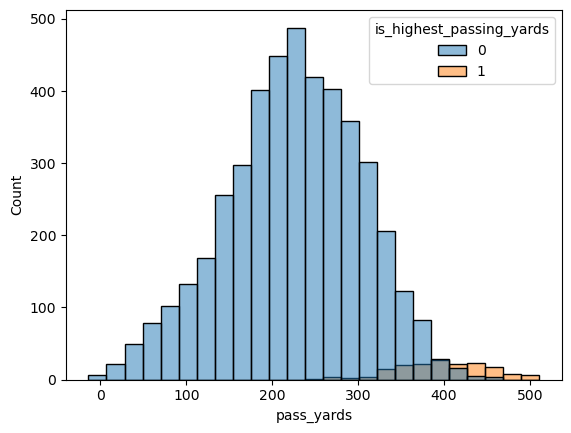

In [56]:
sns.histplot(data=sortski, x="pass_yards", hue='is_highest_passing_yards', bins=25)

In [49]:
sortski

,season,week,passer_id,game_id,passer,home_team,away_team,away_spread,pass_yards,n_passes,total_line,qbteam,home_spread,implied_total,highest_passing_yards_of_week,is_highest_passing_yards
11,2016,1,00-0026158,2016_01_BUF_BAL,J.Flacco,BAL,BUF,3.0,225.0,39,44.5,BAL,-3.0,23.75,419.0,0
16,2016,1,00-0028118,2016_01_BUF_BAL,T.Taylor,BAL,BUF,3.0,108.0,28,44.5,BUF,-3.0,20.75,419.0,0
13,2016,1,00-0027939,2016_01_CAR_DEN,C.Newton,DEN,CAR,-3.0,181.0,38,40.5,CAR,3.0,21.75,419.0,0
28,2016,1,00-0032156,2016_01_CAR_DEN,T.Siemian,DEN,CAR,-3.0,181.0,32,40.5,DEN,3.0,18.75,419.0,0
22,2016,1,00-0029682,2016_01_CHI_HOU,B.Osweiler,HOU,CHI,5.5,230.0,39,43.0,HOU,-5.5,24.25,419.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,2023,21,00-0037834,2023_21_DET_SF,B.Purdy,SF,DET,7.5,310.0,36,52.5,SF,-7.5,30.00,310.0,1
5405,2023,21,00-0033873,2023_21_KC_BAL,P.Mahomes,BAL,KC,4.5,248.0,50,44.0,KC,-4.5,19.75,310.0,0
5406,2023,21,00-0034796,2023_21_KC_BAL,L.Jackson,BAL,KC,4.5,284.0,47,44.0,BAL,-4.5,24.25,310.0,0
5408,2023,22,00-0033873,2023_22_SF_KC,P.Mahomes,KC,SF,-1.5,361.0,55,47.0,KC,1.5,22.75,361.0,1


In [57]:
sortski['implied_total'].value_counts()

21.75    126
21.50    120
23.50    116
20.50    115
22.00    114
        ... 
9.75       1
36.25      1
34.00      1
11.75      1
10.50      1
Name: implied_total, Length: 96, dtype: int64

In [ ]:
#notes
#take average of pass yards from games with same implied total +- 4 points
#find standard dev for these as well
#use appropriate distribution 